# Logistic Regression

Logistic regression is a statistical model that is designed to model the relationship between on or more real-valued independent variables, and a binary dependent variable.

One may begin to understand logistic regression by first considering a logistic model with given parameters, then seeing how the coeffiecents can be estimated ("regressed") from data.

In the general case, given $n$ real-valued independent variables $x_1, ..., x_n \in \mathbb{R}$ and a binary dependent variable $c \in \{0, 1\}$, a logistic regression model will attempt to classify the input vector formed from $x_1, ..., x_n$, into one of two categories.

To make this more concrete, assume the dependent variable is denoting whether a loan application submitted by an individual will be denied or approved. Furthermore, assume $n=2$ where $x_1$ is denoting the individual's net worth and $x_2$ their annual salary, at the time they submitted the loan application.
 
From now on, we'll refer to this mystery individual as Bob.

Ideally, given values for independent variables $x_1, x_2$, we'd like our model to determine the probability that Bob's loan application will be approved - and conversely, the probability that it will be denied.

A natural way of estimating this probability may be as follows. We simply define the dependent variable $c$ as a linear combination of the indpendent variables - clipping the result if necessary.

\begin{align}
    c = min(1, max(0, \beta_{1} x_1 + \beta_{2} x_{2}))
\end{align}

The are two key problems with the above formulation. First, it is only able to model linear relationships between the inputs $x_1$ and $x_2$, and the dependent variable. Second, it becomes "saturated" really quickly and hence, will discard lots of potentially useful information when the values of the inputs are large in magnitude.

Instead, we would like to take a value $l := \beta_{1} x_1 + \beta_{2} x_{2}$ defined on the interval $(-\infty, \infty)$ and map that value to a probability (in the interval $[0, 1]$).

If we assume that the probability of Bob's loan application being approved is $p$, then $\frac{p}{1-p}$ gives us the corresponding $\textit{odds}$ (not probability) of the loan application being approved - essentially, the odds tell us that Bob's loan application being approved is $\frac{p}{1-p}$ times as likely as its not being approved.

If we take the logarithm of the odds, then we get what's known as the $\textit{log-odds}$, which is also referred to as $logit(p)$. And the term $\textbf{logit}$ here is short for [$\textbf{logistic unit}$](https://en.wikipedia.org/wiki/Logit).

\begin{align}
    logit(p) &= log(\frac{p}{1-p}) \\
             &= log(p) - log(1-p)
\end{align}

Now notice that the value of the log-odds is defined on the interval $(-\infty, \infty)$. However, since the log function is [strictly monotonic](https://en.wikipedia.org/wiki/Monotonic_function), the log-odds still serve as a decent measure of the likelihood of Bob's loan application being accepted.

Given this, we can simply take it to be the case that $l := \beta_{1} x_1 + \beta_{2} x_{2}$ $\textbf{defines the log-odds of Bob's loan application being accepted}$. This is actually the definition of a logistic regression relationship between a set of independent variables and a binary dependent variable. Succinctly, a logistic regression relationship is one that is $\textbf{linear in the log odds}$.

Computing the inverse of the log-odds, $logit^{-1}(p)$, we get

\begin{align}
    p = \frac{1}{1+e^{-l}}
\end{align}

The categorical dependent variable $c$ is then computed by rounding $p$ to the nearest integer.

## Generating Data

We're going to generate some sample data and then use maximum likelihood estimation to find the parameters for the logistic model that maximize the likelihood of producing the given data.

To generate data, we can simply sample from two multivariate normal distributions.

In [72]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(12)
num_observations = 5000

X1 = np.random.multivariate_normal([0, 0], [[1., .75], [.75, 1.]], num_observations)
X2 = np.random.multivariate_normal([1, 4], [[1., .75], [.75, 1.]], num_observations)

sample_separable_data = np.vstack((X1, X2)).astype(np.float32)
sample_labels = np.hstack((np.zeros(num_observations), np.ones(num_observations)))

Now let's plot this data together while colour-coding points by their labels.

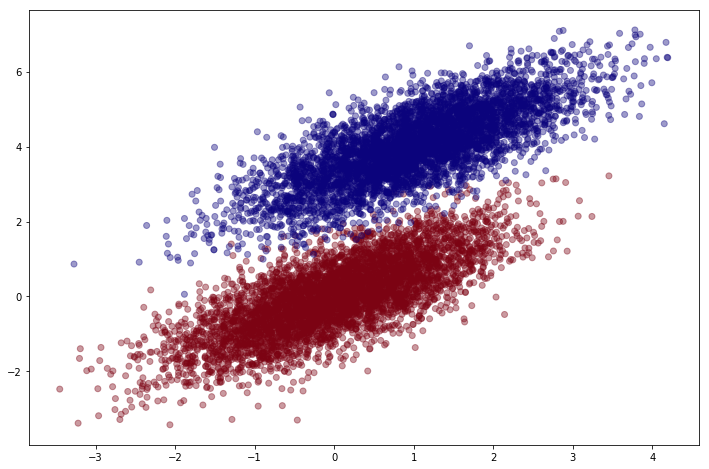

In [73]:
plt.figure(figsize=(12, 8))
coloured_points = np.hstack((np.full(num_observations, '#7c0313'), np.full(num_observations, '#0b037c')))
plt.scatter(sample_separable_data[:, 0],
            sample_separable_data[:, 1],
            c=coloured_points,
            alpha=0.4)

We now implement a numerically stable version of the sigmoid function.

In [74]:
def sigmoid(scores):
    if any(x < 0 for x in scores):
        res = np.exp(scores)
        res /= (1 + res)
    else:
        res = 1 / (1 + np.exp(-scores))
    return res

## Maximizing the Likelihood

When we say we want to "maximize the likelihood", what we mean is this. Given a training dataset $\mathcal{D} = \{(x^{(1)}, y^{(1)}), ..., (x^{(N)}, y^{(N)})\}$ of points, we want to find parameters $\beta_{1}$ and $\beta_{2}$ that maximise the probability of the correct classes $y^{(1)}, ..., y^{(N)}$ being predicted, if the inputs $x^{(1)}, ..., x^{(N)}$ were fed into our logistic regression model. 

Note that this method of estimating the parameters (generally called $\textbf{Maximum Likelihood Estimation}$) can lead to overfitting, but we will avoid this concern for now. Nonetheless, if you are keen to understand how we can deal with overfitting, have a look at [Maximum A Posteriori Estimation](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation) and [Bayesian Logistic Regression](https://stats.stackexchange.com/questions/161101/what-is-the-difference-between-logistic-regression-and-bayesian-logistic-regress).

Below is an expression for the log-likelihood (the log of the likelihood). We will avoid the derivation of this expression for now, although interested readers are referred to Section 4.4.1 of Hastie, Tibsharani and Friedman's [Elements of Statistical Learning](https://web.stanford.edu/~hastie/ElemStatLearn).

\begin{align}
    ll = \sum_{i=1}^{N} y^{(i)}\beta^{T}x^{(i)} - log(1+e^{\beta^{T}x^{(i)}})
\end{align}

We implement this computation below, taking advantage of numpy's vectorized computations.

In [76]:
def log_likelihood(features, targets, weights):
    scores = np.dot(features, weights)
    ll = np.sum(targets * scores - np.log(1 + np.exp(scores)))
    return ll

## Calculating the Gradient

Taking the derivative of $ll$ with respect to the parameter vector $\beta$, we obtain

\begin{align}
    \nabla_{\beta}ll = \sum_{i=1}^{N}y^{(i)}x^{(i)} - \frac{e^{\beta^{T}x^{(i)}}}{1+e^{\beta^{T}x^{(i)}}}x^{(i)}
\end{align}

And if we define the matrices

\begin{align}
    X = [x^{(1)} \ldots x^{(N)}]^T \in \mathbb{R}^{N \times 2} \\
    Y = [y^{(1)} \ldots y^{(N)}]^T \in \mathbb{R}^{N \times 1}
\end{align}

then we can define the derivative as

\begin{align}
    \nabla_{\beta}ll &= [X^T(Y - \widetilde{Y})]
\end{align}
where $\widetilde{Y} \in \mathbb{R}^N$ is the vector of predicted probabilities in the range $[0, 1]$. 

\begin{align}
    \widetilde{Y} = [\frac{e^{\beta^{T}x^{(1)}}}{1+e^{\beta^{T}x^{(1)}}} \ldots \frac{e^{\beta^{T}x^{(N)}}}{1+e^{\beta^{T}x^{(N)}}}]^T
\end{align}

Note also that $\nabla_{\beta}ll$ is a $2 \times 1$ column vector telling us how the value of the log-likelihood changes as each of the parameters, $\beta_1$ and $\beta_2$ changes.

## Building the Logistic Regression Pipeline

Now we're ready to build the logistic regression pipeline.

In [75]:
def logistic_regression(features, targets, num_steps, learning_rate, add_intercept=False):
    if add_intercept:
        intercept = np.ones((features.shape[0], 1))
        features = np.hstack((intercept, features))
    
    weights = np.zeros(features.shape[1])
    
    for step in range(num_steps):
        scores = np.dot(features, weights)
        predictions = sigmoid(scores)
        
        # Update weights using stochastic gradient descent
        output_error_signal = targets - predictions
        gradient = np.dot(features.T, output_error_signal)
        weights += learning_rate * gradient
        
        # Print log-likelihood after some given time interval
        if step % 10000 == 0:
            print(log_likelihood(features, targets, weights))
            
    return weights

Now let's run the model and see whether everything works well.

In [77]:
weights = logistic_regression(sample_separable_data,
                              sample_labels,
                              num_steps=int(1e05),
                              learning_rate=5e-5,
                              add_intercept=True)

-4346.264779152365
-148.70672276805357
-142.9649362310784
-141.5453030715737
-141.060319659308
-140.87031585891606
-140.79025912753812
-140.75505002269915
-140.73914503180956
-140.73183498915876


As expected, the log-likelihood increases over the sequence of training steps.

To increase our confidence that we've implemented the mathematics correctly, we're going to compare the results returned by our implementation, to those returned by sk-learn's logistic regression implementation.

In [78]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(fit_intercept=True, C=1e15)
clf.fit(sample_separable_data, sample_labels)

print('sk-learn weights: {} {}'.format(clf.intercept_, clf.coef_))
print('raw implementation weights: {}'.format(weights))

sk-learn weights: [-13.99400797] [[-5.02712572  8.23286799]]
raw implementation weights: [-14.0178565   -5.03280465   8.24664683]


c:\users\maduo\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


As expected, the weights of the two implementations are very close to one another.

## Computing the Accuracy of our Model

To get the accuracy of our model, we simply compute the log-odds (logit) for each of the data points in the training set

\begin{align}
    l = X\beta = [x^{(1)} \ldots x^{(N)}]^T \beta
\end{align}

We then compute $\texttt{sigmoid(l)}$ and round the result to the nearest integer, to obtain the category, 0 or 1, into which each of the data points is classified.

We compare these results with the ground-truth labels.

In [79]:
# Here `1` is essentially x^0
data_with_intercept = np.hstack((np.ones((sample_separable_data.shape[0], 1)),
                                 sample_separable_data))

# No need for transpose, as each row in `data_with_intercept` holds features
# for a different data point in the training set
final_scores = np.dot(data_with_intercept, weights)
predictions = np.round(sigmoid(final_scores))

accuracy = (predictions == sample_labels).sum().astype(float) / len(predictions)
sklearn_accuracy = clf.score(sample_separable_data, sample_labels)

print('Accuracy from raw implementation: {}'.format(accuracy))
print('Accuracy from sk-learn: {}'.format(sklearn_accuracy))

Accuracy from raw implementation: 0.9948
Accuracy from sk-learn: 0.9948


Now we'll plot the predictions of the raw implementation logistic regression model, using the colour green to mark correctly classified points and red to mark incorrectly classified points.

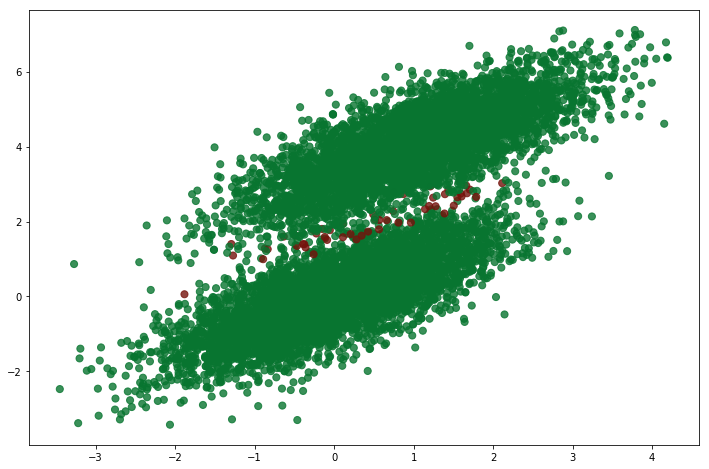

In [80]:
plt.figure(figsize=(12,8))
coloured_points = np.full(len(predictions), '#ffffff')

for i in range(len(predictions)):
    if predictions[i] == sample_labels[i]:
        coloured_points[i] = '#087530'
    else:
        coloured_points[i] = '#75130c'
        
plt.scatter(sample_separable_data[:, 0],
            sample_separable_data[:, 1],
            c=coloured_points,
            alpha=0.8,
            s=50)

As we can see, most of the incorrectly classified points lie at the margin between the two distributions, where the uncertainty over which distribution a given points belongs to, is greatest.

## Conclusion

In this post we built a logistic regression model from scratch and compared our results with those of the (production-tested) library sk-learn, and found our results to be similar to sk-learn's results.

Implementing machine-learning models from scratch is often a good way of reinforcing a lot of the theoretical knowledge that you'll encounter when following machine-learning courses.

Note that while logistic regression managed to separate the above data quite well, with more complex data distributions, this may not the case. A few examples of datasets from other data distributions are given below. Try and see how well our logistic regression model can learn to classify points in these datasets. If the model exhibits poor performance, can you think of ways to transform the data points in these datasets so that the model will be able to learn a better separating margin? (Hint: See [Kernels](https://en.wikipedia.org/wiki/Kernel_method) - which allow us to transform the data points from one feature space to another - and for good measure, also see [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)).

In [84]:
def plot_scatter_plot(X1, X2):
    sample_separable_data = np.vstack((X1, X2)).astype(np.float32)
    
    coloured_points = np.hstack((np.full(num_observations, '#7c0313'), np.full(num_observations, '#0b037c')))
    plt.scatter(sample_separable_data[:, 0],
                sample_separable_data[:, 1],
                c=coloured_points,
                alpha=0.4)

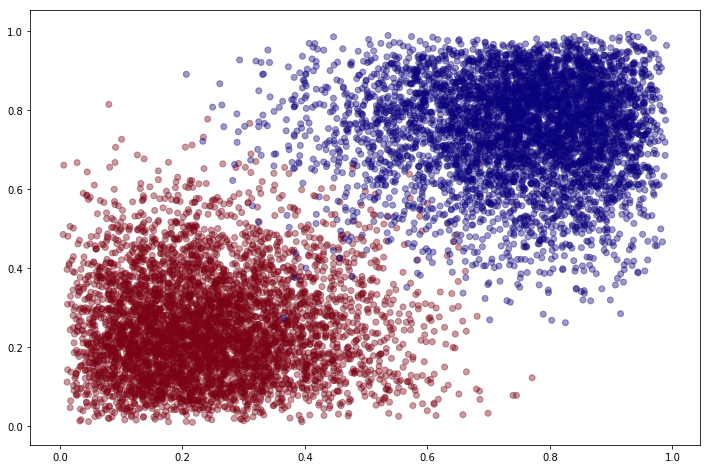

In [83]:
# Two multivariate beta distributions
X1 = np.stack((np.random.beta(2.5, 7.5, num_observations),
               np.random.beta(2.5, 7.5, num_observations)),
               axis=1)
X2 = np.stack((np.random.beta(7.5, 2.5, num_observations),
               np.random.beta(7.5, 2.5, num_observations)),
               axis=1)

plt.figure(figsize=(12,8))
plot_scatter_plot(X1, X2)

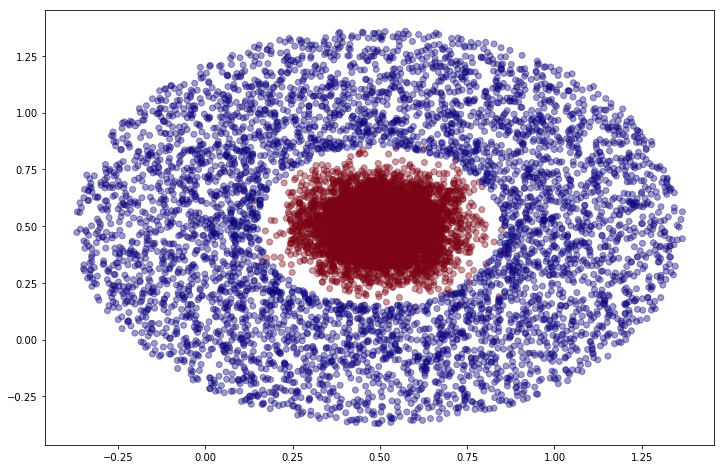

In [81]:
# Multivariate uni-modal beta distribution
X1 = np.stack((np.random.beta(10., 10., num_observations),
               np.random.beta(10., 10., num_observations)),
               axis=1)

theta = np.linspace(0, 2*np.pi, num_observations)
min_radius = 0.35
scale = (1 - min_radius) * 0.8
radii = min_radius + np.random.rand(num_observations) * scale
circle_centre = (.5, .5)

# Points stochastically dispersed on a circle
X2_x = radii * np.cos(theta) + circle_centre[0]
X2_y = radii * np.sin(theta) + circle_centre[1]

X2 = np.stack((X2_x, X2_y), axis=1)

plt.figure(figsize=(12,8))
plot_scatter_plot(X1, X2)

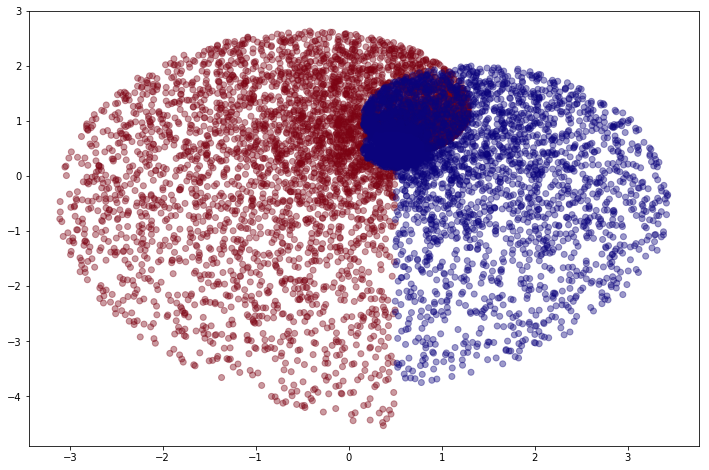

In [82]:
theta = np.linspace(0, 1.5*np.pi, num_observations)
min_radius = 0.35
circle_centre = (.5, .5)

def construct_spiral(custom_theta):
    radii = min_radius + np.random.rand(num_observations) * custom_theta
    x = radii * np.cos(custom_theta) + circle_centre[0]
    y = radii * np.sin(custom_theta) + circle_centre[1]
    return np.stack((x, y), axis=1)

# Two spirals, one clockwise and one anti-clockwise
X1 = construct_spiral(theta)
X2 = construct_spiral(-theta)

plt.figure(figsize=(12,8))
plot_scatter_plot(X1, X2)

## References

Becker N. $\textit{Logistic Regression from Scratch in Python}$. Available From: https://beckernick.github.io/logistic-regression-from-scratch [Accessed 11th Oct. 2018]